In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

import lmfit
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()




#dataSet

## Some functions

In [12]:
# get center of thresholded image

def calc_thresh(data):
    shape = np.shape(data)
    thresh = np.zeros(shape)
    sigma = 0.4

    if len(shape) == 4:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*0.5,0,1)

    elif len(shape) == 3:
        blurred = gaussian_filter(data, sigma=sigma)
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*0.5,0,1)

    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [Y_center,X_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen


def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

def thermal(x, x0, amp, sigma, order = 15):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog(2, res, order)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1-(( x - x0 ) / sigma) **2) **(3/2)
    return amp * np.where(res > 0, res, 0)

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th, order=15) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


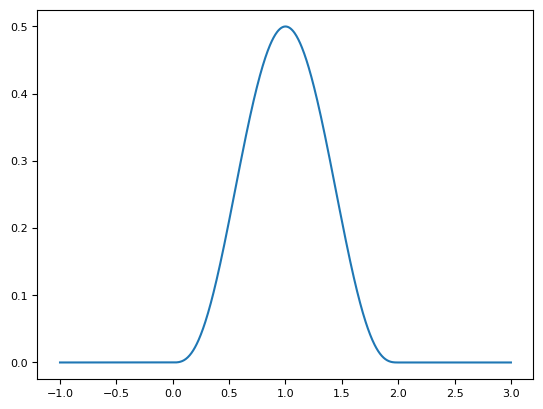

In [3]:
x = np.linspace(-1,3, 1000)
plt.plot(x, Thomas_Fermi_1d(x, 1, 1, 1))
plt.show()

## Import Data

In [3]:
# import data
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()


shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"

# # load the data from HDF5 files
# dataSetDict = {
#     dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
#     for i in [0] # range(len(groupList))
# }

# selecte the data for centain camera
dataSet = read_hdf5_file(filePath, "images/MOT_3D_Camera/in_situ_absorption")
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# rechunck the data for parallel computing
dataSet = auto_rechunk(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

OD = dataSet["OD"]

OD_np = OD.to_numpy()

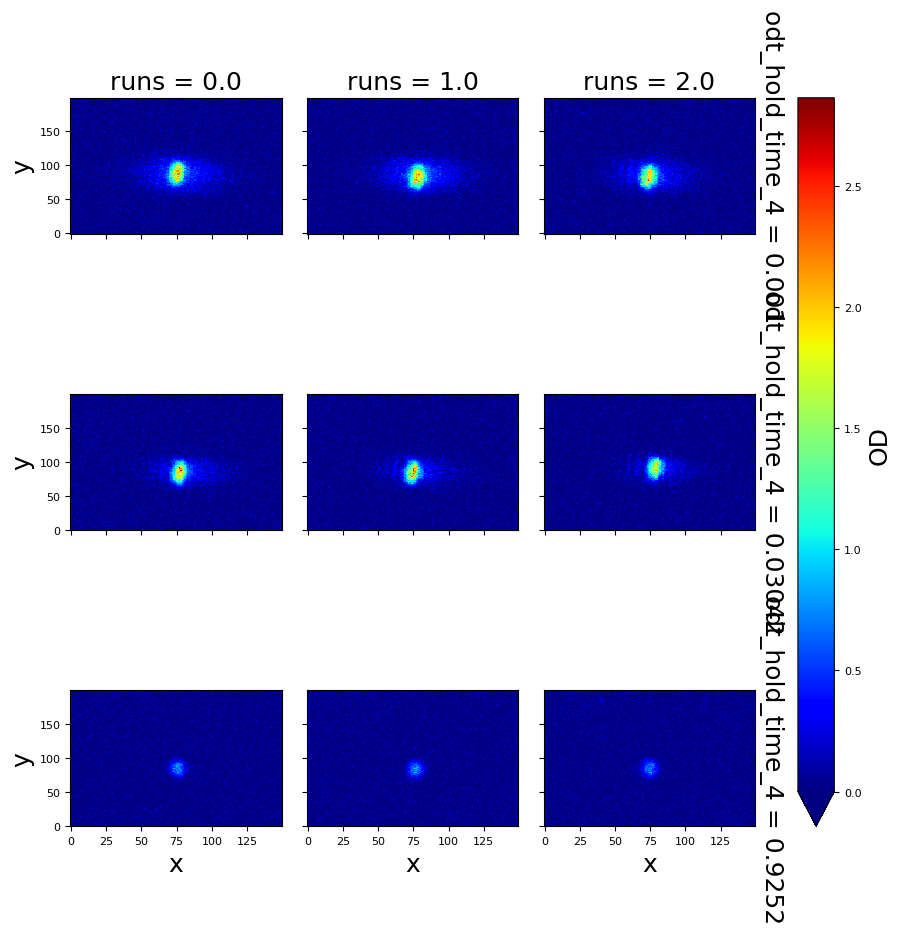

In [4]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[1], row=scanAxis[0])
plt.show()

## Guess center

ToDo: Crop from center guess

In [4]:
# from opencv import moments
data = OD_np

thresh = OD_

# thresh = gaussian_filter(thresh, sigma=0.1)
# thresh = np.where(thresh<0.1,0,1)


#M = moments(thresh)

In [15]:
thresh = calc_thresh(OD_np)
center = calc_cen_bulk(thresh)

shape = np.shape(OD_np)
cropOD = np.zeros((shape[0], shape[1], 150, 150))

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        cropOD[i,j] = OD_np[i,j, round(center[i,j,1]-75):round(center[i,j,1]+75), round(center[i,j,0]-75):round(center[i,j,0]+75)]

thresh = calc_thresh(cropOD)
center = calc_cen_bulk(thresh)

In [36]:
for i in range(0, shape[0]):
    for j in range(0,shape[1]):
        print(np.count_nonzero(thresh[i,j, 815:965, 885:1035]))
        print(np.count_nonzero(thresh[i,j]))
        print()

145
145

216
216

170
170

116
116

124
124

174
174

148
150

98
99

127
131



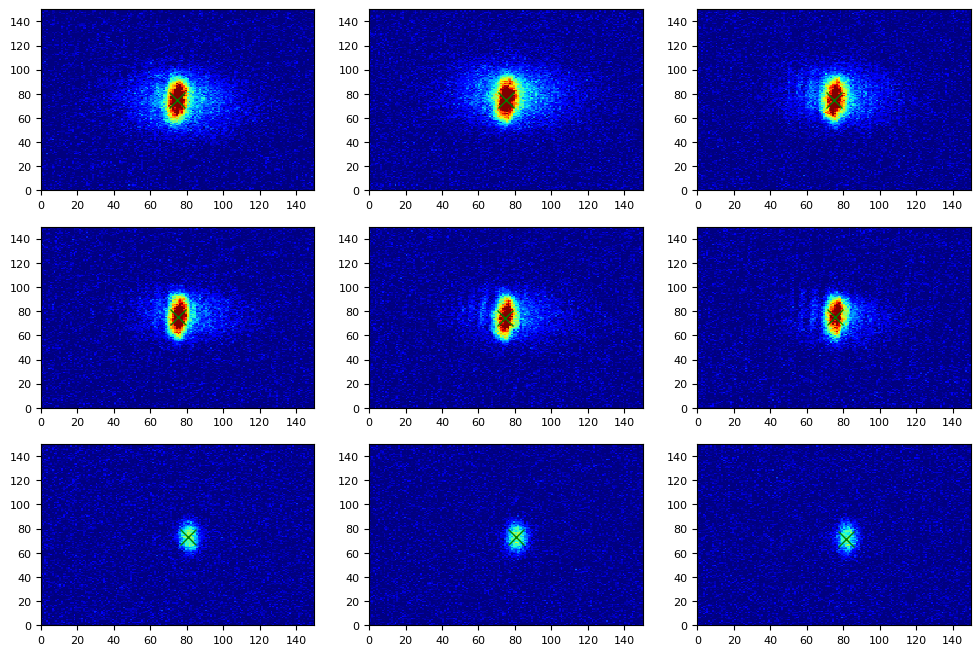

In [16]:
fsize = (12,8)

nr_plots = 3

# %matplotlib notebook
# fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

# for i in range(0,nr_plots):
#     for j in range(0,nr_plots):
#         # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
#         #ax[i][j].pcolormesh(thresh[i,j, 815:965, 885:1035], cmap='jet', vmin=0, vmax=1.5, alpha=1)
#         ax[i][j].pcolormesh(thresh[i,j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
#         #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
#         ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
# plt.show()

# fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
# for i in range(0,nr_plots):
#     for j in range(0,nr_plots):
#         ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
#         #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
#         #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
#         ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
# plt.show()
#
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=1.5)
        #ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', color='g', markersize=12)
plt.show()

## Guess width

In [17]:
def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)
    BEC_width_guess = np.zeros((shape[0], shape[1], 2))

    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
            BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])

    return BEC_width_guess

BEC_width_guess = guess_BEC_width(thresh, center)

print(BEC_width_guess)

[[[ 7. 25.]
  [ 8. 26.]
  [ 8. 26.]]

 [[ 8. 20.]
  [ 7. 21.]
  [ 7. 28.]]

 [[10. 19.]
  [ 9. 18.]
  [ 9. 18.]]]


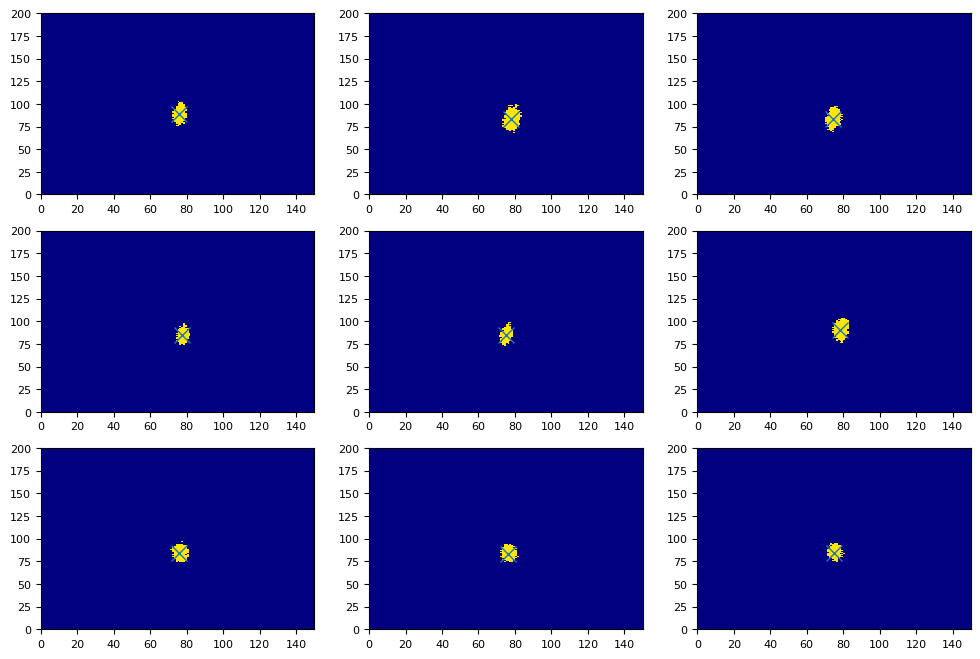

In [10]:
# %matplotlib notebook
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
plt.show()


## Mask array

In [11]:
masked = np.where(thresh==0, cropOD, np.nan)
np.shape(masked)

(3, 3, 200, 150)

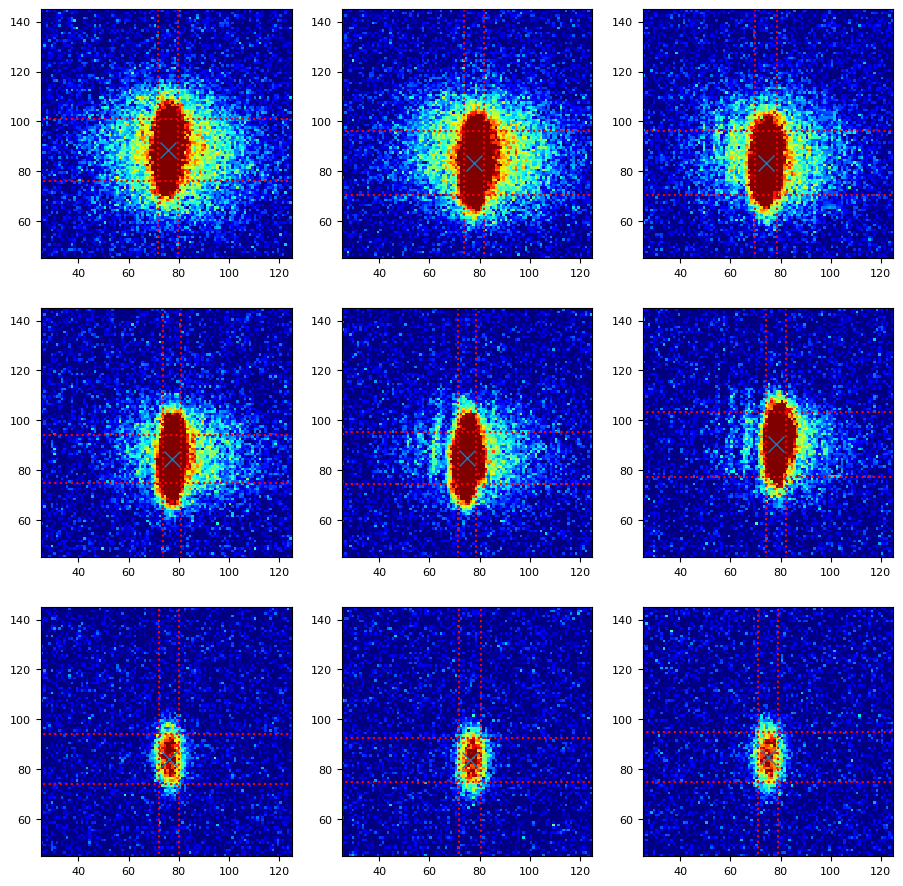

In [12]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=(11,11))

cut_factor = 1

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        #print(np.nanmax(masked[i,j]))
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(masked[i][j], cmap='jet', vmin=0, vmax=0.5, alpha=1)
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=0.7, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(center[i,j,0],center[i,j,1], marker='x', markersize=12)
        alpha=1
        ax[i][j].hlines(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].hlines(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2, 0, 150, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].vlines(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')
        ax[i][j].vlines(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2, 0, 200, color='r',alpha=alpha,linestyles='dotted')

        ax[i][j].set_xlim(25,125)
        ax[i][j].set_ylim(45,145)
plt.show()

## Cut out region of interest for thermal fitting guess

In [13]:
shape = np.shape(masked)

X_guess = np.zeros((shape[0], shape[1], shape[3]))
Y_guess = np.zeros((shape[0], shape[1], shape[2]))
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess[i,j] = np.sum(masked[i,j,round(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2) , :], 0) / len(masked[i,j,round(center[i,j,1] - cut_factor * BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + cut_factor * BEC_width_guess[i,j,1]/2),0])

        Y_guess[i,j] = np.sum(masked[i,j, :, round(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2)], 1) / len(masked[i,j,0,round(center[i,j,0] - cut_factor * BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + cut_factor * BEC_width_guess[i,j,0]/2)])


#print(X_guess)

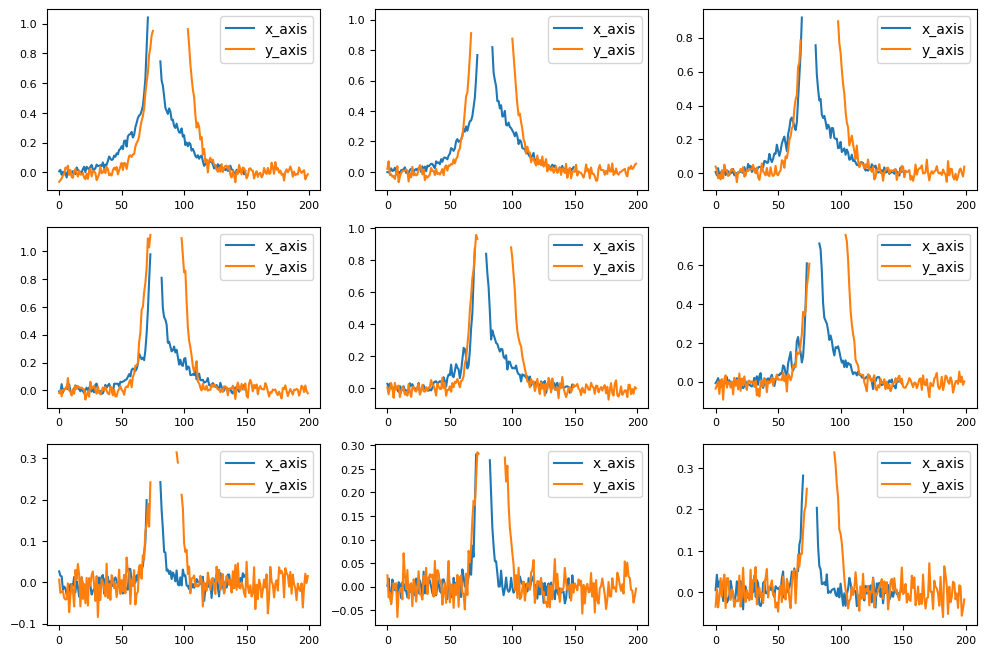

In [14]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(X_guess[i,j], label = 'x_axis')
        ax[i,j].plot(Y_guess[i,j], label = 'y_axis')
        ax[i,j].legend(fontsize=10)
plt.show()


## Fitting 1D gaussian

In [15]:
#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 2, 3))

p0 = np.ones((shape[0], shape[1], 2, 3))

p0[:, :, :, 0] = center
p0[:, :, :, 1] = BEC_width_guess / 2.355
p0[:, :, :, 2] = 0.1


for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j, 0], pcov = curve_fit(gaussian, x, X_guess[i,j] , p0[i, j, 0], nan_policy='omit')
        popt[i,j, 1], pcov = curve_fit(gaussian, y, Y_guess[i,j] , p0[i, j, 1], nan_policy='omit')

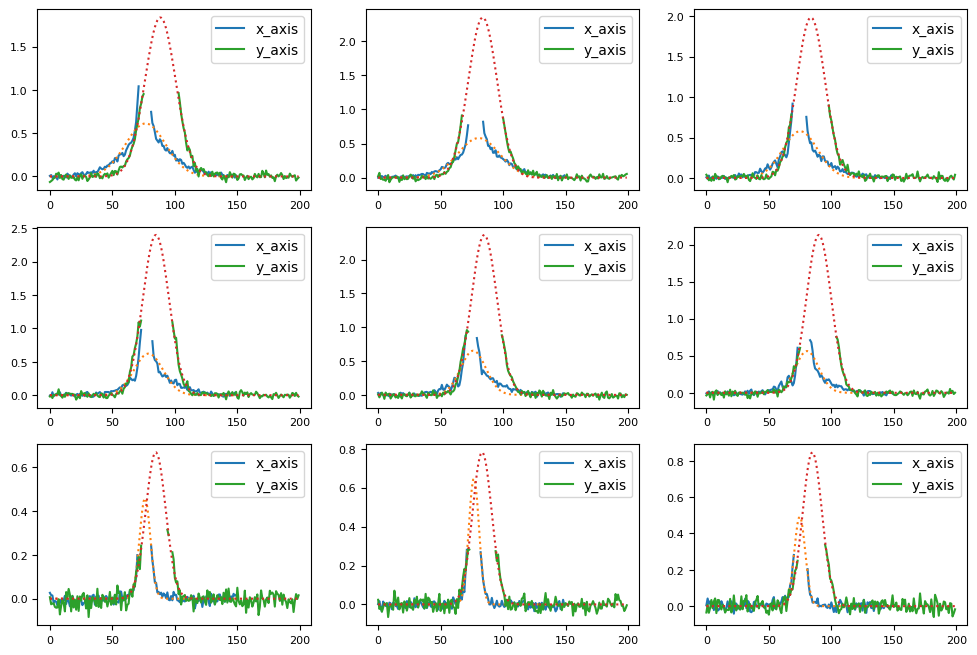

In [16]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(x, X_guess[i,j], label = 'x_axis')
        ax[i,j].plot(x, gaussian(x, *popt[i,j,0]), linestyle='dotted')

        ax[i,j].plot(y, Y_guess[i,j], label = 'y_axis')
        ax[i,j].plot(y, gaussian(y, *popt[i,j,1]), linestyle='dotted')
        ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

## Try with not masked array


In [17]:
shape = np.shape(masked)

X_guess_og = np.zeros((shape[0], shape[1], shape[3]))
Y_guess_og = np.zeros((shape[0], shape[1], shape[2]))

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        X_guess_og[i,j] = np.sum(cropOD[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2) , :], 0) / len(masked[i,j,round(center[i,j,1] - BEC_width_guess[i,j,1]/2) : round(center[i,j,1] + BEC_width_guess[i,j,1]/2),0])

        Y_guess_og[i,j] = np.sum(cropOD[i,j, :, round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)], 1) / len(masked[i,j,0,round(center[i,j,0] - BEC_width_guess[i,j,0]/2) : round(center[i,j,0] + BEC_width_guess[i,j,0]/2)])

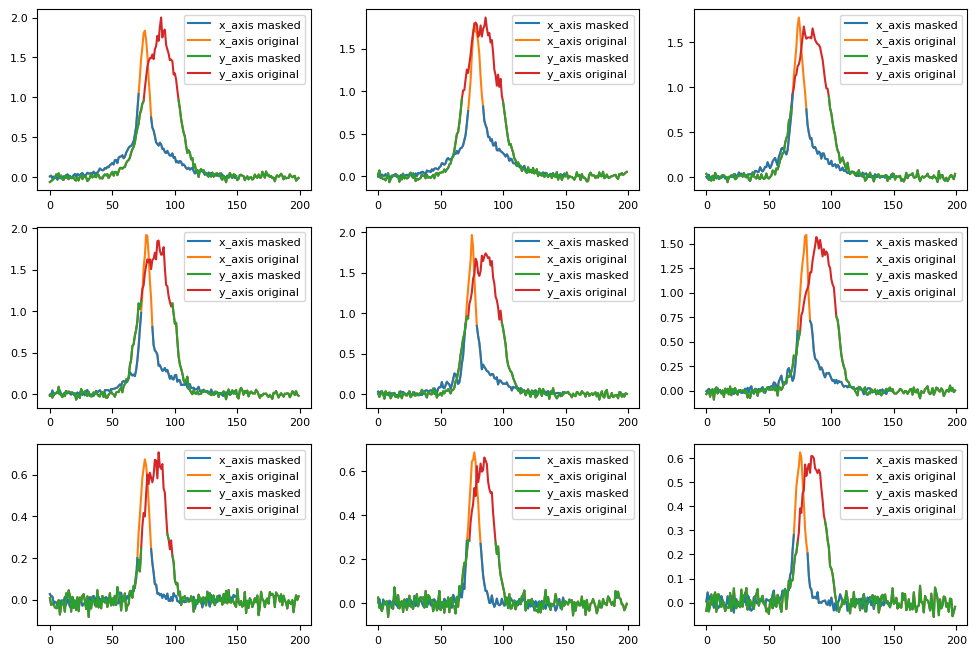

In [18]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        ax[i,j].plot(x, X_guess[i,j], label = 'x_axis masked',zorder=5)
        ax[i,j].plot(x, X_guess_og[i,j], label = 'x_axis original')
#         ax[i,j].legend(fontsize=10)
# plt.show()
#
# fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
#
# for i in range(0, shape[0]):
#     for j in range(0, shape[1]):
        ax[i,j].plot(y, Y_guess[i,j], label = 'y_axis masked',zorder=5)
        ax[i,j].plot(y, Y_guess_og[i,j], label = 'y_axis original')
        ax[i,j].legend(fontsize=8)
plt.show()

## Bimodal 1d Fit

In [19]:
#[nr images x, nr images y, X / Y, center / sigma]
x = np.linspace(0,149,150)
y = np.linspace(0,199, 200)

popt = np.zeros((shape[0], shape[1], 6))

p0 = np.ones((shape[0], shape[1], 6))

max = np.zeros((shape[0], shape[1]))

for i in range(0, shape[0]):
    max[i] = np.ndarray.max(X_guess_og[i],axis=1)


p0[:, :, 0] = center[:, :, 0]  # center BEC
p0[:, :, 1] = center[:, :, 0]   # center th
p0[:, :, 2] = 0.7 * max          # amp BEC
p0[:, :, 3] = 0.3 * max         # amp th
p0[:, :, 4] = BEC_width_guess[:, :, 0]   # sigma BEC
p0[:, :, 5] = BEC_width_guess[:, :, 0] * 3          # sigma th

start = time.time()
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        popt[i,j], pcov = curve_fit(density_1d, x, X_guess_og[i,j] , p0[i, j], nan_policy='omit')
stop = time.time()




print(f'fitting time: {(stop-start)*1e3} ms')
        #popt[i,j, 1], pcov = curve_fit(density_1d, y, Y_guess_og[i,j] , p0[i, j, 1], nan_policy='omit')

fitting time: 106.31179809570312 ms


In [20]:
# Fitting x without math constr
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []
start = time.time()
for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max[i,j], True, 0, 1.3 * np.max(X_guess_og[i,j])),
            ('amp_th', 0.3 * max[i,j], True, 0, 1.3*np.max(X_guess_og[i,j])),
            ('sigma_bec',BEC_width_guess[i,j,0], True, 0, 50),
            ('sigma_th', 3*BEC_width_guess[i,j,0], True, 0, 50)
        )
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        temp_res.append(res)
    result_x.append(temp_res)
stop = time.time()

In [21]:
# Fitting x with math constraint on width
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

result_x = []
start = time.time()
for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,0], True,0, 200),
            ('x0_th',center[i,j,0], True,0, 200),
            ('amp_bec', 0.7 * max[i,j], True, 0, 1.3 * np.max(Y_guess_og[i,j])),
            ('amp_th', 0.3 * max[i,j], True, 0, 1.3*np.max(Y_guess_og[i,j])),
            ('deltax', 2* BEC_width_guess[i,j,0], True,0,50),
            ('sigma_bec',BEC_width_guess[i,j,0], True, 0, 50)
        )
        params.add('sigma_th', min=0, expr=f'sigma_bec+deltax'
        )
        res = fitmodel.fit(X_guess_og[i,j], x=x, params=params)
        temp_res.append(res)
    result_x.append(temp_res)
stop = time.time()

In [142]:
S = np.zeros((shape[0], shape[1]))
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        S[i,j] = np.max(Y_guess_og[i,j])/(popt[i,j,2] + popt[i,j,3])
print(S)


[[0.69218233 0.66625539 0.61833837]
 [0.58760028 0.5772473  0.61120507]
 [0.69197339 0.7760333  0.6094938 ]]


In [202]:
#fitting Y on popt
# math constr

fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

p0_y = np.ones((shape[0], shape[1], 6))
popt_y = np.zeros((shape[0], shape[1], 6))

result_y = []
start = time.time()
for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        params = lmfit.Parameters()
        params.add_many(
            ('x0_bec', center[i,j,1], True,0, 200),
            ('x0_th',center[i,j,1], True,0, 200),
            ('amp_bec', S[i,j]* popt[i,j,2], True, 0, 1.3 * np.max(Y_guess_og[i,j])),
            ('amp_th', S[i,j]* popt[i,j,3], True, 0, 1.3*np.max(Y_guess_og[i,j])),
            ('deltax', 0, True, 0,50),
            ('sigma_bec',BEC_width_guess[i,j,0], True, 0, 15)
        )
        params.add('sigma_th',popt[i,j,5], min=0, expr=f'sigma_bec + deltax'
        )
        res = fitmodel.fit(Y_guess_og[i,j], x=y, params=params)
        temp_res.append(res)
    result_y.append(temp_res)
stop = time.time()

In [227]:
# Fitting Y
# without mathematical constraint
# Fix most
fitmodel = lmfit.Model(density_1d,independent_vars=['x'])

p0_y = np.ones((shape[0], shape[1], 6))
popt_y = np.zeros((shape[0], shape[1], 6))

S = np.zeros((shape[0], shape[1]))
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        S[i,j] = np.max(Y_guess_og[i,j])/(result_x[i,j].best_values['amp_bec'] + result_x[i,j].best_values['amp_th'])
print(S[0,0]* popt[0,0,3]+S[0,0]* popt[0,0,2])

result_y = []
start = time.time()
for i in range(0, shape[0]):
    temp_res = []
    for j in range(0, shape[1]):
        params = lmfit.Parameters()

        bval = result_x[i][j].best_values
        params.add_many(
            ('x0_bec', center[i,j,1], False,0, 200),
            ('x0_th',center[i,j,1], False,0, 200),
            ('amp_bec', S[i,j]* bval['amp_bec'], True, 0, 1.3 * np.max(Y_guess_og[i,j])),
            ('amp_th', S[i,j]* bval['amp_th'], False),
            ('sigma_bec',BEC_width_guess[i,j,1], True, 0, 50),
            ('sigma_th',bval['sigma_th'], False)
        )
        res = fitmodel.fit(Y_guess_og[i,j], x=y, params=params)
        temp_res.append(res)
    result_y.append(temp_res)
stop = time.time()

type: list indices must be integers or slices, not tuple

In [24]:

for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(popt[i,j])
        print(result_x[i][j].best_values)
        #print(result_y[i][j].best_values)
        print(BEC_width_guess[i,j,1])
        print("")



[75.41570333 77.33388115  2.56706786  0.32435386  9.02534473 21.78913789]
{'x0_bec': 75.41570631345125, 'x0_th': 77.33387669882647, 'amp_bec': 2.5670677717602537, 'amp_th': 0.32435362458962513, 'sigma_bec': 9.025351656015761, 'sigma_th': 21.789148834558127}
25.0

[77.87651631 81.11230043  2.46976259  0.33019881  9.77967464 21.30093181]
{'x0_bec': 77.87414667926795, 'x0_th': 81.00942140743041, 'amp_bec': 2.4251361988169013, 'amp_th': 0.336733100911304, 'sigma_bec': 9.771032230037038, 'sigma_th': 21.0114608336347}
26.0

[73.89357632 76.27664646  2.4312179   0.27440553  9.98643754 20.45775545]
{'x0_bec': 73.87690614810727, 'x0_th': 75.75396443024098, 'amp_bec': 2.1748880271879374, 'amp_th': 0.32117568442009115, 'sigma_bec': 9.814809230807409, 'sigma_th': 18.256517221101156}
26.0

[77.11393592 81.40236184  2.88921236  0.26104054  8.62447632 18.73504104]
{'x0_bec': 77.08861286232403, 'x0_th': 79.69001135621787, 'amp_bec': 2.4064163373141456, 'amp_th': 0.34799624740698715, 'sigma_bec': 8.351

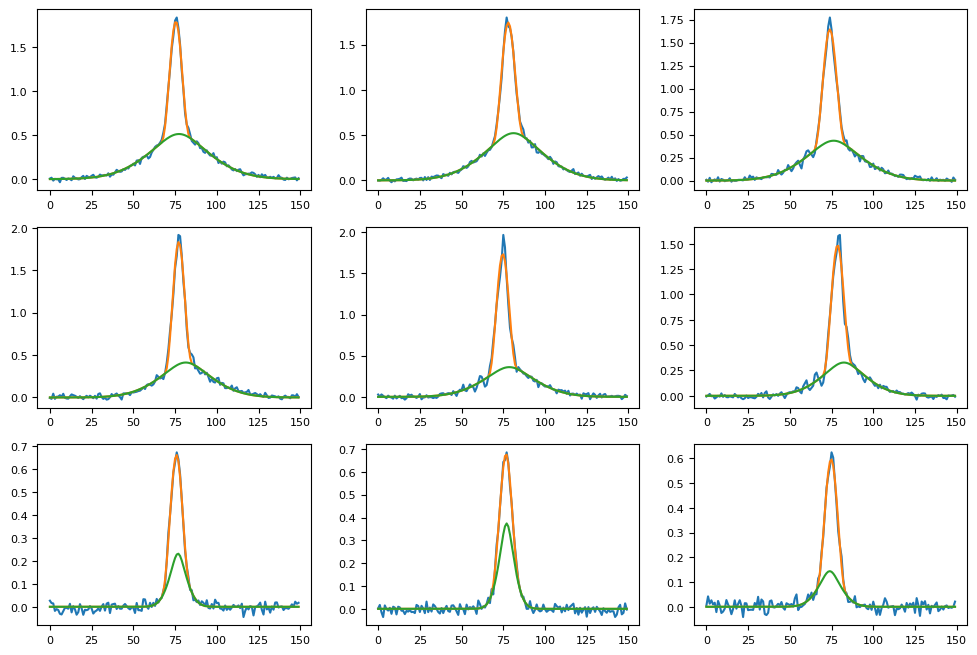

In [22]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, *popt[i,j]), label = lab)
        ax[i,j].plot(x, thermal(x, popt[i,j,1], popt[i,j, 3], popt[i,j, 5]))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

In [28]:
print(11.8*1.93)
print(18.7*1.22)

22.774
22.814


In [ ]:
plt.show()

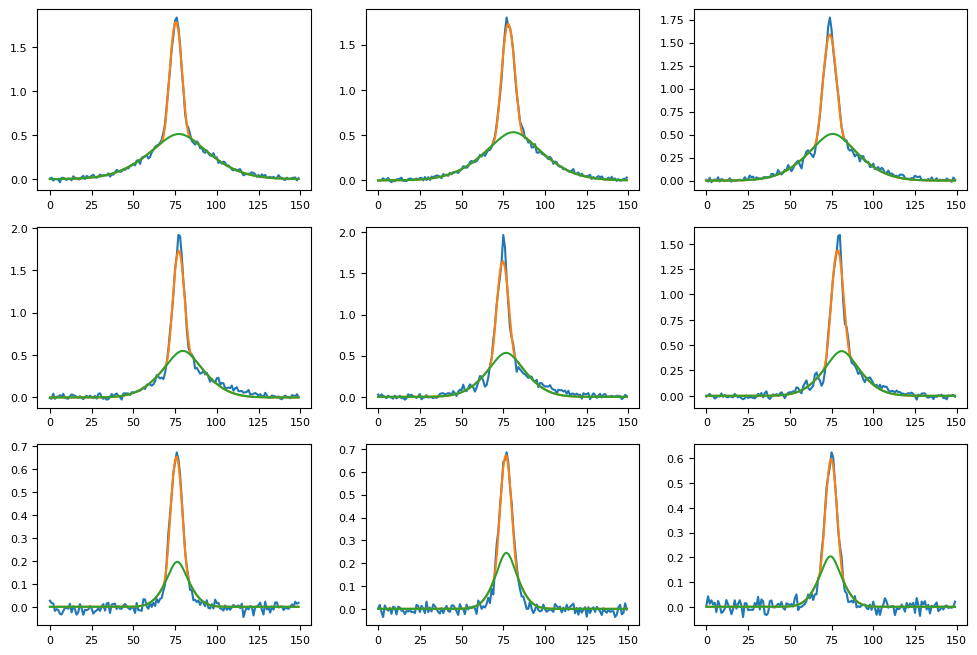

In [216]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_x[i][j].best_values
        ax[i,j].plot(x, X_guess_og[i,j])
        ax[i,j].plot(x, density_1d(x, **result_x[i][j].best_values), label = lab)
        ax[i,j].plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))


plt.show()

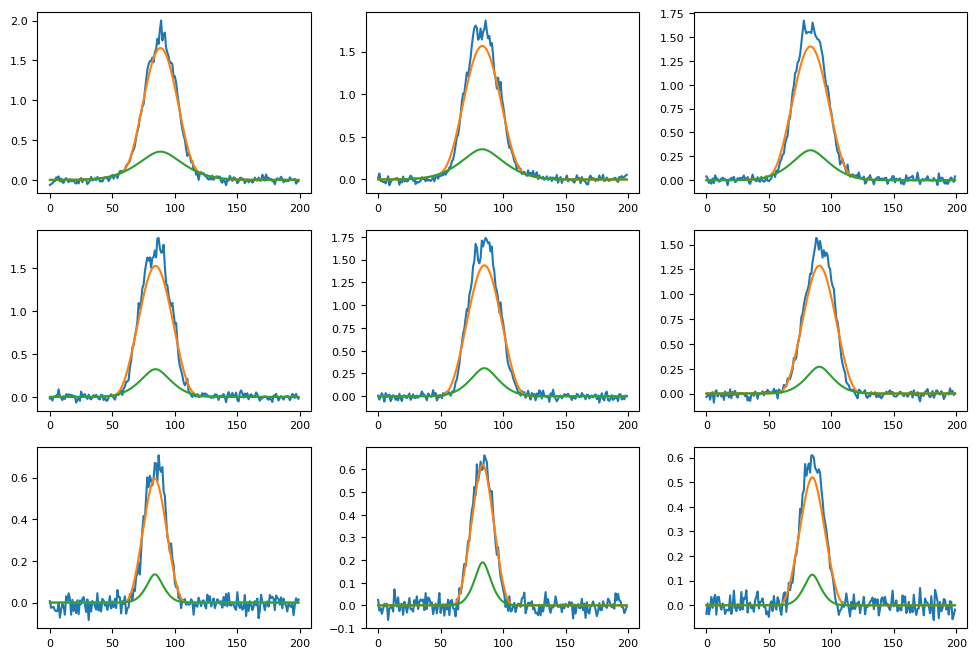

In [221]:
fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        #lab = f"A$_{{BEC}}$ = {popt[i,j,0]:.1f} \n A$_{{th}}$ = {popt[i,j,1]:.1f} "
        bval = result_y[i][j].best_values
        ax[i,j].plot(y, Y_guess_og[i,j])
        ax[i,j].plot(y, density_1d(y, **result_y[i][j].best_values), label = lab)
        ax[i,j].plot(y, thermal(y, bval['x0_th'], bval['amp_th'], bval['sigma_th']))
        #ax[i,j].plot(y, thermal(y, **result[i][j].best_values))


        #ax[i,j].legend(fontsize=10)
        ax[i,j].set_facecolor('#FFFFFF')
plt.show()

In [63]:
for i in range(0,3):
    for j in range(0,3):
        print(p0_y[i,j])
        print(popt_y[i,j])
        print("")

[88.5        88.5         2.36427288  0.29873033 25.         21.78913789]
[0. 0. 0. 0. 0. 0.]

[83.31944444 83.31944444  2.00635046  0.26824219 26.         21.30093181]
[0. 0. 0. 0. 0. 0.]

[83.28654971 83.28654971  2.14473074  0.24207043 26.         20.45775545]
[0. 0. 0. 0. 0. 0.]

[84.52136752 84.52136752  2.35846552  0.21308753 19.         18.73504104]
[0. 0. 0. 0. 0. 0.]

[84.98387097 84.98387097  2.21373578  0.18182394 21.         18.55393163]
[0. 0. 0. 0. 0. 0.]

[90.42528736 90.42528736  1.79170364  0.15810669 26.         15.99073945]
[0. 0. 0. 0. 0. 0.]

[84.00684932 84.00684932  0.76816174  0.12878971 20.          5.96931421]
[0. 0. 0. 0. 0. 0.]

[83.63970588 83.63970588  0.66093309  0.25375932 18.          5.34970959]
[0. 0. 0. 0. 0. 0.]

[8.47401575e+01 8.47401575e+01 7.75240700e-01 7.78106534e-02
 2.00000000e+01 7.98461584e+00]
[0. 0. 0. 0. 0. 0.]



In [134]:
print(result[0][0].best_values)

{'x0_bec': 88.71878723899935, 'x0_th': 87.86994848219054, 'amp_bec': 2.601808340467902, 'amp_th': 0.29982321034674164, 'sigma_bec': 28.01890078868497, 'sigma_th': 28.018901081653368}
